In [1]:
from time import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from scipy.optimize import curve_fit
from scipy.optimize import minimize
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib import rc
from sklearn.metrics import r2_score

from matplotlib import ticker

import numba
from numba import jit

In [24]:
def r2_G_two_taus(J_start_list, J_end_list, returns, delta, taus_try, G_try):
    """
    Fits a model with two timescales for predicting the impact on returns.

    Inputs:
    - J_start_list: array with shape (m, t), where m is the number of meta-orders and t is the number of trial timescales;
                    each entry indicates the start of the meta-order impact for a specific timescale.
    - J_end_list: array with shape (m, t), where m is the number of meta-orders and t is the number of trial timescales;
                  each entry indicates the end of the meta-order impact for a specific timescale.
    - returns: array of actual returns corresponding to each meta-order.
    - delta: float representing the concavity parameter for the impact function.
    - taus_try: array of trial impact-decay timescales (length t).
    - G_try: initial guess for the weight estimate (float).

    Outputs:
    - r2_delta_tau: array with shape (t, t) containing the R-squared values for each combination of two timescales.
    - G_matrix: array with shape (t, t) containing the estimated prefactor for each combination of two timescales.
    - beta_matrix: array with shape (t, t) containing the estimated normalized weight for each combination of two timescales.
    """
    N = taus_try.shape[0]  # Number of trial timescales
    r2_delta_tau = np.zeros([N, N])  # Initialize array to store R-squared values
    G_matrix = np.zeros([N, N])      # Initialize array to store prefactor estimates
    beta_matrix = np.zeros([N, N])   # Initialize array to store normalized weight estimates
    
    # Loop over all combinations of two trial timescales
    for tau1_idx, tau1 in enumerate(taus_try):
        Jend1 = J_end_list[:, tau1_idx]     # End impact for the first timescale
        Jstart1 = J_start_list[:, tau1_idx] # Start impact for the first timescale
        for tau2_idx, tau2 in enumerate(taus_try):
            Jend2 = J_end_list[:, tau2_idx]     # End impact for the second timescale
            Jstart2 = J_start_list[:, tau2_idx] # Start impact for the second timescale

            def best_params(delta):
                """Find the best model parameters (G, beta) by minimizing the loss function."""
                def loss(G):
                    # Compute the predicted impact at the start and end of the meta-order
                    Iend = G[1] * np.sign(Jend1) * np.abs(Jend1) ** delta + \
                           (1 - G[1]) * np.sign(Jend2) * np.abs(Jend2) ** delta
                    Istart = G[1] * np.sign(Jstart1) * np.abs(Jstart1) ** delta + \
                             (1 - G[1]) * np.sign(Jstart2) * np.abs(Jstart2) ** delta

                    # Compute the loss as the mean squared error between predicted and actual returns
                    res = ((returns - G[0] * (Iend - Istart)) ** 2).mean()
                    return res

                # Optimize the loss function to find the best G and beta
                result = minimize(loss, np.array([G_try, 0.6]), bounds=((0, None), (0, 1)))
                r2 = 1.0 - result.fun / (returns ** 2).mean()  # Calculate R-squared

                return dict(
                    G=result.x[0],          # Best prefactor
                    best_beta=result.x[1],  # Best normalized weight
                    r2=r2                   # R-squared value
                )

            # Store the results for the current combination of timescales
            results = best_params(delta)
            r2_delta_tau[tau1_idx, tau2_idx] = results['r2']
            G_matrix[tau1_idx, tau2_idx] = results['G']
            beta_matrix[tau1_idx, tau2_idx] = results['best_beta']

    # Return the matrices containing R-squared, G, and beta values for each timescale combination
    return r2_delta_tau, G_matrix, beta_matrix



def r2_G_three_taus(J_start_list, J_end_list, returns, delta, taus_try, tau1_idx, tau2_idx):
    """
    Fits a model with three timescales for predicting the impact on returns.

    Inputs:
    - J_start_list: array with shape (m, t), where m is the number of meta-orders and t is the number of trial timescales;
                    each entry indicates the start of the meta-order impact for a specific timescale.
    - J_end_list: array with shape (m, t), where m is the number of meta-orders and t is the number of trial timescales;
                  each entry indicates the end of the meta-order impact for a specific timescale.
    - returns: array of actual returns corresponding to each meta-order.
    - delta: float representing the concavity parameter for the impact function.
    - taus_try: array of trial impact-decay timescales (length t).
    - tau1_idx: integer index representing the first chosen timescale in taus_try.
    - tau2_idx: integer index representing the second chosen timescale in taus_try.

    Outputs:
    - r2_delta_tau: list containing the R-squared values for each combination of three timescales.
    - G_matrix: list containing the estimated prefactor for each combination of three timescales.
    - a: list containing the estimated weight for the first timescale for each combination of three timescales.
    - b: list containing the estimated weight for the second timescale for each combination of three timescales.
    """
    r2_delta_tau = []  # Initialize list to store R-squared values
    G_matrix = []      # Initialize list to store prefactor estimates
    a = []             # Initialize list to store weight estimates for the first timescale
    b = []             # Initialize list to store weight estimates for the second timescale
    
    # Extract impact for the first and second chosen timescales
    Jend1 = J_end_list[:, tau1_idx]     # End impact for the first timescale
    Jstart1 = J_start_list[:, tau1_idx] # Start impact for the first timescale
    
    Jend2 = J_end_list[:, tau2_idx]     # End impact for the second timescale
    Jstart2 = J_start_list[:, tau2_idx] # Start impact for the second timescale
    
    # Loop over all trial timescales to find the best third timescale
    for tau3_idx, tau3 in enumerate(taus_try):
        Jend3 = J_end_list[:, tau3_idx]     # End impact for the third timescale
        Jstart3 = J_start_list[:, tau3_idx] # Start impact for the third timescale

        def best_params(delta):
            """Find the best model parameters (G, a, b) by minimizing the loss function."""
            def loss(G):
                # Compute the predicted impact at the start and end of the meta-order
                Iend = (G[1] * np.sign(Jend1) * np.abs(Jend1) ** delta +
                        G[2] * np.sign(Jend2) * np.abs(Jend2) ** delta +
                        (1 - G[1] - G[2]) * np.sign(Jend3) * np.abs(Jend3) ** delta)
                Istart = (G[1] * np.sign(Jstart1) * np.abs(Jstart1) ** delta +
                          G[2] * np.sign(Jstart2) * np.abs(Jstart2) ** delta +
                          (1 - G[1] - G[2]) * np.sign(Jstart3) * np.abs(Jstart3) ** delta)
                
                # Compute the loss as the mean squared error between predicted and actual returns
                res = ((returns - G[0] * (Iend - Istart)) ** 2).mean()
                return res

            def ieq(G):
                # Inequality constraint to ensure that the sum of the weights does not exceed 1
                return (1 - G[1] - G[2])

            # Optimize the loss function to find the best G, a, and b, with constraints
            constraints = {'type': 'ineq', 'fun': ieq}
            result = minimize(loss, np.array([1.5, 0.6, 0.3]), 
                              bounds=((0, None), (0.5, 1), (0.2, 0.5)),  
                              constraints=constraints) 
            
            # Calculate R-squared
            r2 = 1.0 - result.fun / (returns ** 2).mean()
            
            return dict(
                G=result.x[0],  # Best prefactor
                a=result.x[1],  # Best weight for the first timescale
                b=result.x[2],  # Best weight for the second timescale
                r2=r2           # R-squared value
            )

        # Store the results for the current combination of three timescales
        results = best_params(delta)
        r2_delta_tau.append(results['r2'])
        G_matrix.append(results['G'])
        a.append(results['a'])
        b.append(results['b'])

    # Return the lists containing R-squared, G, a, and b values for each timescale combination
    return r2_delta_tau, G_matrix, a, b

@numba.jit(nopython=True)
def compute_J_fast_large(q, t, epsilon, tau, duration):
    """
    Computes exponentially decaying impact for a TWAP (Time-Weighted Average Price) strategy.

    Inputs:
    - q: array representing the normalized trade size |Q/V_D|, where Q is the meta-order volume and V_D is the daily volume.
    - t: array of timestamps (in minutes) corresponding to the trades.
    - epsilon: array of signs of the trade size Q/V_D, indicating the direction of the trade.
    - tau: impact-decay timescale (in minutes).
    - duration: array of trade durations for each meta-order (in minutes).

    Outputs:
    - J_start: array of starting impact values for each trade, incorporating the decay from previous trades.
    - J_end: array of ending impact values for each trade, incorporating the decay and additional impact from the current trade.
    - J_inst: array of instantaneous impact values calculated during the trade.
    """
    N = q.size  # Number of trades/meta-orders
    assert t.size == N  # Ensure the size of timestamps matches the number of trades
    
    J_inst = np.zeros(q.size)  # Initialize array for instantaneous impact
    J_end = np.zeros(q.size)   # Initialize array for end impact
    J_start = np.zeros(q.size) # Initialize array for start impact

    t_old = t[0]  # Initialize the previous timestamp
    J_start[0] = 0  # Starting impact for the first trade is zero
    
    # Compute the initial instantaneous and end impact for the first trade
    J_inst[0] = (1 - np.exp(-duration[0] / tau)) * q[0] * epsilon[0] / duration[0] * tau
    J_end[0] = J_inst[0]
    
    # Loop through all subsequent trades/meta-orders
    for idx in range(1, N):
        t_new = t[idx]  # Current timestamp
        frac_t = (t_new - t_old) / tau  # Fraction of the timescale elapsed
        
        # Calculate the starting impact considering the decay from the previous trade
        J_start[idx] = np.exp(-frac_t) * J_end[idx - 1]
        
        # Compute the instantaneous impact for the current trade
        J_inst[idx] = (1 - np.exp(-duration[idx] / tau)) * q[idx] * epsilon[idx] / duration[idx] * tau
        
        # Calculate the ending impact considering the decay and the additional impact from the current trade
        J_end[idx] = J_inst[idx] + np.exp(-(frac_t + duration[idx] / tau)) * J_end[idx - 1]
        
        t_old = t_new  # Update the previous timestamp

    return J_start, J_end, J_inst


def compute_J_ret(df_list, tau_shortlong):
    """
    Creates the impact process for a list of dataframes, each containing meta-orders for a specific contract.

    Inputs:
    - df_list: list of dataframes, where each dataframe contains meta-order data for a specific futures contract.
    - tau_shortlong: array of trial impact-decay timescales (in days, to be converted to minutes).

    Outputs:
    - J_start_list: list of arrays containing starting impact values for each trade across all timescales and contracts.
    - J_end_list: list of arrays containing ending impact values for each trade across all timescales and contracts.
    - returns_list: list of arrays containing returns normalized by volatility for each contract.
    """
    J_start_list = []  # Initialize list to store start impact arrays for all contracts
    J_end_list = []    # Initialize list to store end impact arrays for all contracts
    J_inst_list = []   # Initialize list to store instantaneous impact arrays for all contracts
    returns_list = []  # Initialize list to store returns for all contracts
    
    # Loop through each contract's dataframe
    for jdx, prd in enumerate(df_list):
        df_large = prd.copy()  # Create a copy of the current dataframe
        
        # Extract relevant columns as arrays
        q = df_large['Q'].abs().values         # Absolute trade sizes |Q/V_D|
        epsilon = np.sign(df_large['Q'].values) # Trade direction signs
        t = df_large['time'].values            # Timestamps (in minutes)
        duration = df_large['T'].values        # Trade durations (in minutes)

        # Initialize arrays to store impact for different timescales
        J_start = np.zeros((q.size, tau_shortlong.size))
        J_end = np.zeros((q.size, tau_shortlong.size))
        J_inst = np.zeros((q.size, tau_shortlong.size))
        
        # Loop through each trial timescale
        for idx, tau in enumerate(tau_shortlong):
            # Convert timescale from days to minutes and compute impacts using `compute_J_fast_large`
            J_start[:, idx], J_end[:, idx], J_inst[:, idx] = compute_J_fast_large(q, t, epsilon, tau * 24 * 60, duration)

        # Append the computed impact arrays for the current contract to the lists
        J_start_list.append(J_start)
        J_end_list.append(J_end)
        J_inst_list.append(J_inst)
        
        # Calculate returns normalized by volatility for the current contract
        volatility_pts = df_large['volatility_pts'].values
        returns = (prd['Mid_end'] - prd['Mid_start']) / volatility_pts
        returns_list.append(returns)

    return J_start_list, J_end_list, returns_list


def max_deltataur2(r2, taus, deltas):
    """
    Finds the maximum value in the input matrix `r2` and returns the corresponding indices and values.
    
    Inputs:
    - r2: 2D matrix containing R-squared values.
    - taus: Array of tau values corresponding to the columns of `r2`.
    - deltas: Array of delta values corresponding to the rows of `r2`.
    
    Outputs:
    - Maximum R-squared value and the corresponding delta and tau indices and values.
    """
    delta_idx_MLE, tau_idx_MLE = np.unravel_index(r2.argmax(), r2.shape)  # Find indices of the max value in r2
    delta_MLE = deltas[delta_idx_MLE]  # Delta corresponding to the max R-squared
    tau_MLE = taus[tau_idx_MLE]        # Tau corresponding to the max R-squared
    return r2.max(), delta_idx_MLE, delta_MLE, tau_idx_MLE, tau_MLE


def plot_matrix(r2_delta_tau_pos, taus_try, deltas_try, title, a1, vmin, vmax, step, xlabel, ylabel):
    """
    Plots a 2D matrix with customized axis labels, color range, and title.
    
    Inputs:
    - r2_delta_tau_pos: 2D matrix to be plotted.
    - taus_try: Array of tau values for the x-axis.
    - deltas_try: Array of delta values for the y-axis.
    - title: Title of the plot.
    - a1: Index offset for both axes to focus on a specific region of the matrix.
    - vmin, vmax: Minimum and maximum values for the color scale.
    - step: Step size for the axis labels.
    - xlabel, ylabel: Labels for the x and y axes.
    """
    x1 = r2_delta_tau_pos.shape[0]
    x2 = r2_delta_tau_pos.shape[1]
    im_ratio = x1 / x2  # Calculate aspect ratio of the image

    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(r2_delta_tau_pos[a1:, a1:], cmap=cm.get_cmap('Blues'), vmin=vmin, vmax=vmax)  # Display matrix

    # Set axis ticks and labels
    ax.set_xticks(np.arange(0, taus_try.shape[0] - a1, step))
    ax.set_xticklabels(np.around(taus_try[a1::step], 1))
    ax.set_yticks(np.arange(0, deltas_try.shape[0] - a1, step))
    ax.set_yticklabels(np.around(deltas_try[a1::step], 2))

    # Set axis labels and title
    ax.set_ylabel(ylabel, size=25)
    ax.set_xlabel(xlabel, size=25)
    ax.set_title(title, size=20)
    
    # Adjust layout and add colorbar
    fig.tight_layout()
    cbar = fig.colorbar(im, orientation='vertical', fraction=0.047 * im_ratio)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.update_ticks()

# Import simulated Meta-order Data

In [6]:
df = pd.read_csv('meta_order_simdata-1.csv')

In [22]:
#Number of meta-order
df.shape

(59964, 7)

In [25]:
#Columns
df

Index(['Mid_start', 'Mid_end', 'volatility_pts', 'Q', 'T', 'time', 'Product'], dtype='object')

## Explanation Columns:
    
    
- Mid_start: The midprice at the start of the meta-order.
- Mid_end: The midprice at the end of the meta-order.
- volatility_pts: The price volatility during the meta-order, expressed in basis points.
- Q: The meta-order volume normalized by the average daily volume, indicating the size of the order relative to typical daily trading volume.
- T: The duration of the meta-order in minutes.
- time: The timestamp of the trade or event, recorded in minutes.
- Product: The name or identifier of the futures contract being traded.

In [23]:
#Data Frame
df.head()

,Mid_start,Mid_end,volatility_pts,Q,T,time,Product
0,338.1453,341.4080,6.287999,0.013068,268.0,4320,0
1,351.1015,356.9022,6.722799,0.014789,310.0,5760,0
2,346.8933,345.9403,5.564961,0.021324,212.0,10080,0
3,336.8345,334.2041,5.212244,0.009146,183.0,11520,0
4,347.8543,342.8836,6.012487,-0.011854,243.0,14400,0


In [9]:
# Create list per product
df_list = []
for i in df.Product.unique():
    df_list.append(df[df['Product'] == i])

# Fitting Procedure

Normalized price returns $r_t$ are regressed against the contemporaneous increments of a power-law price impact of the form
\begin{equation}\label{eq:solutionI}
        I_t =  \sum_{n=1}^N w_n \mathrm{sgn}(J^n_t) |J^n_t|^{c_n},
\end{equation}

## Two-timescales n=2, c = 0.5

In [42]:
# Compute the latent variable J for different test time-scales in tau_shortlong
N = 20
taus_try = np.concatenate([np.array([0.0001]),(10**(np.linspace(-1,2, N-1)))])
tau_shortlong = np.concatenate([np.array([0.05,0.1,0.2]), taus_try[3:]],axis = 0)

J_start_list , J_end_list, returns_list = compute_J_ret(df_list, tau_shortlong)

In [43]:
# Regress the Model for two time scales
J_start = np.concatenate(J_start_list, axis = 0)
J_end =  np.concatenate(J_end_list, axis = 0)
returns =  np.concatenate(returns_list, axis = 0)

deltas_try = np.arange(10,101,5)/100

r2,G0,beta = r2_G_two_taus(J_start, J_end,returns, 0.5,tau_shortlong,1.7)

### Result


In [44]:
# Best fit parameters
r2_mle, tau1_idx_MLE, tau1_MLE, tau2_idx_MLE, tau2_MLE = max_deltataur2(r2,tau_shortlong,tau_shortlong)
print('r^2: ',r2_mle, 
      'tau_1: ',tau1_MLE,
     'tau_2: ', tau2_MLE, 
      '\n vec{w}: ', G0[tau1_idx_MLE,tau2_idx_MLE],
      'w_1: ',beta[tau1_idx_MLE,tau2_idx_MLE])

r^2:  0.024822947990808863 tau_1:  0.46415888336127786 tau_2:  68.12920690579608 
 vec{w}:  1.7796980146986316 w_1:  0.7459498081990764


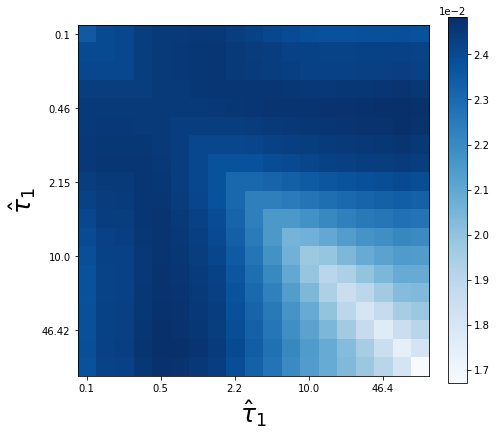

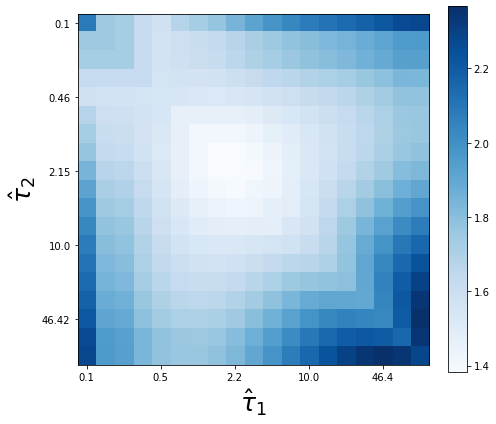

In [45]:
# Plot the R^2 matrix and the models Pre-factor 
plot_matrix(r2, tau_shortlong, tau_shortlong,r"" , a1=1, vmin = None, vmax =None ,step = 4,
            ylabel = r'$\hat \tau_1$', xlabel = r'$\hat \tau_1$')
plt.tight_layout()
plot_matrix(G0 , tau_shortlong, tau_shortlong,r"" , a1=1, vmin = None, vmax =None,step = 4,
            ylabel = r'$\hat \tau_2$', xlabel = r'$\hat \tau_1$')

plt.tight_layout()

## Three-timescales n=3, c = 0.5

In [46]:
# Fit the third time-scale with the 2 best fitted time-scales
r2_delta_tau, G_matrix,a,b = r2_G_three_taus(J_start, J_end,returns, 0.5, 
                                                                     tau_shortlong, tau1_idx_MLE, tau2_idx_MLE)

### Results

In [47]:
# Best Fit Paramters
idx_mle = np.argmax(r2_delta_tau)
print(r'$w_1/||w||$:',a[idx_mle],r' $w_2/||w||$:',b[idx_mle], r'$w_3/||w||$:',1-a[idx_mle]-b[idx_mle])
print(r'$\vec{w}$:',G_matrix[idx_mle])

$w_1/||w||$: 0.6506664966467611  $w_2/||w||$: 0.2225236876601003 $w_3/||w||$: 0.12680981569313857
$\vec{w}$: 1.774887876707795


In [53]:
# Summary Results
idx_mle, tau_shortlong[np.array([tau1_idx_MLE,tau2_idx_MLE,11])], np.max(r2_delta_tau)

(11, array([ 0.46415888, 68.12920691,  4.64158883]), 0.02492580509740161)

## Two concavities n =2, $\tau_1$ = 0.5, $\tau_2$ = 65 days

In [49]:
# Fit concavities for the two best time scales
r2_td, G0_td, beta_td= r2_G_two_deltas(J_start ,
               J_end , returns, deltas_try, deltas_try, tau1_idx_MLE, tau2_idx_MLE,1.7)

### Results

In [50]:
# Best Fit Parameters
max_deltataur2(r2_td,deltas_try,deltas_try)

(0.02482595179229452, 7, 0.45, 9, 0.55)

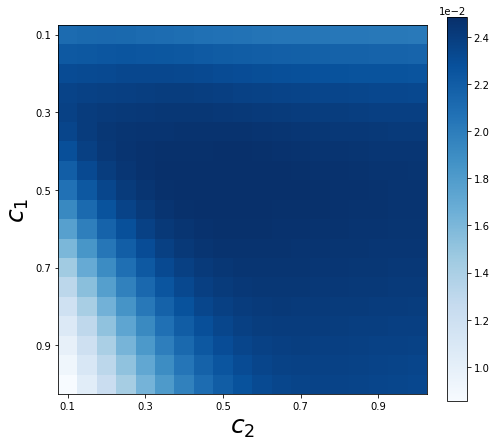

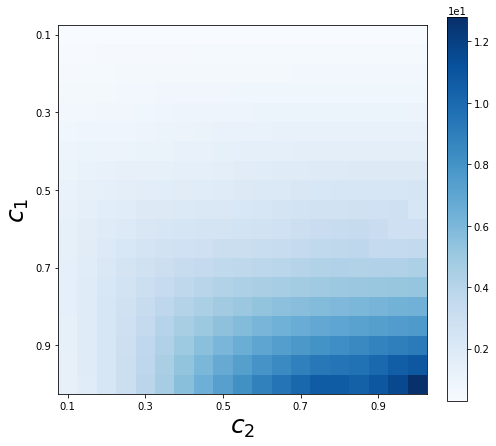

In [51]:
plot_matrix(r2_td, deltas_try ,deltas_try,r"" , a1=0, vmin = None, vmax =None ,step = 4,
            ylabel = r'$ c_1$', xlabel = r'$ c_2$')
plt.tight_layout()
plot_matrix(G0_td, deltas_try ,deltas_try,r"" , a1=0, vmin = None, vmax =None ,step = 4,
            ylabel = r'$ c_1$', xlabel = r'$ c_2$')
plt.tight_layout()